### Impute Data to get rid of outliers (Step 13)
#### Author: S. Sakib Hasan

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
os.chdir(os.path.join(os.getcwd(), "..", "..", "data"));

In [3]:
df = pd.read_csv("combined-season-data.csv", index_col=False);

In [4]:
df.head()

,season,GW,at_home,player_id,team_id,opponent_id,champion_ls,top5_ls,bottom5_ls,promoted_ts,...,result_pgw,saves,saves_pgw,team_form,threat,threat_pgw,total_points_pgw,yellow_cards,yellow_cards_pgw,total_points
0,2016,1,0,1,20,4,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
1,2016,1,1,2,6,17,0,1,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
2,2016,1,1,4,1,9,0,0,0,0,...,0.0,0,0.0,0.0,23.0,0.0,0.0,0,0.0,2
3,2016,1,0,6,18,13,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
4,2016,1,1,7,4,20,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0


In [5]:
df.tail()

,season,GW,at_home,player_id,team_id,opponent_id,champion_ls,top5_ls,bottom5_ls,promoted_ts,...,result_pgw,saves,saves_pgw,team_form,threat,threat_pgw,total_points_pgw,yellow_cards,yellow_cards_pgw,total_points
76140,2019,15,0,1223,28,13,0,0,1,0,...,0.0,0,0.0,-0.25,0.0,3.0,2.0,0,0.0,1
76141,2019,15,0,1224,17,11,0,0,0,0,...,1.0,0,0.0,0.50,0.0,0.0,0.0,0,0.0,0
76142,2019,15,0,1225,21,1,0,1,0,0,...,-1.0,0,0.0,-0.50,0.0,0.0,0.0,0,0.0,0
76143,2019,15,0,1226,27,4,0,1,0,0,...,0.0,0,0.0,-0.25,4.0,25.0,2.0,0,0.0,2
76144,2019,15,0,1227,27,4,0,1,0,0,...,0.0,0,0.0,-0.25,0.0,0.0,0.0,0,0.0,0


In [6]:
df.isnull().sum().sum()

0

In [7]:
df.duplicated().sum()

0

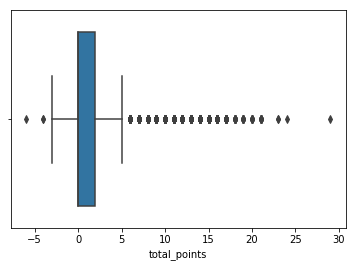

In [8]:
sns.boxplot(x=df['total_points'])

(array([2.0000e+01, 4.2642e+04, 2.5166e+04, 5.1420e+03, 2.3400e+03,
        5.6000e+02, 2.3800e+02, 3.3000e+01, 3.0000e+00, 1.0000e+00]),
 array([-6. , -2.5,  1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. ]),
 <a list of 10 Patch objects>)

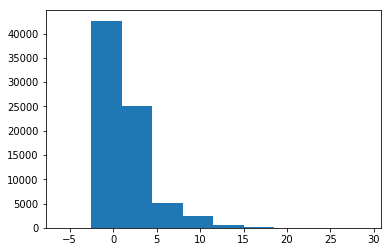

In [9]:
plt.hist(df["total_points"])

In [10]:
distribution_df = pd.DataFrame();

In [11]:
distribution_df["points"] = np.unique(df["total_points"])

In [12]:
def countPoints(point):
    return df[df["total_points"] == point].shape[0]

In [13]:
distribution_df["data_count"] = distribution_df["points"].apply(lambda point: countPoints(point))

In [14]:
distribution_df["data_percent"] = distribution_df["data_count"].apply(lambda count: round(count / df.shape[0] * 100, 3))

In [15]:
distribution_df

,points,data_count,data_percent
0,-6,1,0.001
1,-4,2,0.003
2,-3,17,0.022
3,-2,94,0.123
4,-1,255,0.335
5,0,42293,55.543
6,1,11631,15.275
7,2,10154,13.335
8,3,2748,3.609
9,4,633,0.831


In [16]:
imputer = KNNImputer()

In [17]:
outlier_threshold = 500;

In [18]:
outlier_points = list(distribution_df[distribution_df["data_count"] <= outlier_threshold]["points"])

In [19]:
def impute_outlier(outlier_points):
    for point in outlier_points:
        total_points = "total_points";
        player_id = "player_id";
        opponent_id = "opponent_id";
        at_home = "at_home";
        season = "season";
        gw = "GW";

        # get the overall df based on the current outlier point
        overall_df = df[df[total_points] == point];

        for index, row in overall_df.iterrows():
            cond1 = (df[player_id] == row[player_id]) & (df[opponent_id] == row[opponent_id]) & (df[at_home] == row[at_home])
            cond2 = (df[player_id] == row[player_id]) & (df[opponent_id] == row[opponent_id])
            cond3 = (df[player_id] == row[player_id])

            lookup_df = df[cond1]
            cond = cond1
            impute_cond = 1

            if lookup_df.shape[0] == 1 or len(np.unique(list(lookup_df[total_points]))) == 1:
                lookup_df = df[cond2]
                cond = cond2
                impute_cond = 2
            if lookup_df.shape[0] == 1 or len(np.unique(list(lookup_df[total_points]))) == 1:
                lookup_df = df[cond3]
                cond = cond3
                impute_cond = 3
            if lookup_df.shape[0] == 1 or len(np.unique(list(lookup_df[total_points]))) == 1:
                break;

            # set the total point at that index to null
            df.at[index, total_points] = None
            lookup_df = df[cond]

            impute_df = pd.DataFrame(data=imputer.fit_transform(lookup_df), columns=df.columns)
            full_cond_impute_df = (impute_df[season] == row[season]) & (impute_df[gw] == row[gw]);

            if impute_cond == 1:
                full_cond_impute_df = full_cond_impute_df & (impute_df[player_id] == row[player_id]) & (impute_df[opponent_id] == row[opponent_id]) & (impute_df[at_home] == row[at_home])
            elif impute_cond == 2:
                full_cond_impute_df = full_cond_impute_df & (impute_df[player_id] == row[player_id]) & (impute_df[opponent_id] == row[opponent_id])
            elif impute_cond == 3:
                full_cond_impute_df = full_cond_impute_df & (impute_df[player_id] == row[player_id])

            full_cond_df = (cond) & (df[season] == row[season]) & (df[gw] == row[gw])
            df.loc[full_cond_df, total_points] = round(impute_df[full_cond_impute_df].iloc[0][total_points], 0)

        print("Done imputing outlier point {}".format(point));

In [20]:
def refresh_distribution():
    distribution_df = pd.DataFrame();
    distribution_df["points"] = np.unique(df["total_points"])
    distribution_df["data_count"] = distribution_df["points"].apply(lambda point: countPoints(point))
    distribution_df["data_percent"] = distribution_df["data_count"].apply(lambda count: round(count / df.shape[0] * 100, 3));
    return distribution_df;

In [21]:
while len(outlier_points) > 1:
    print("Current outlier points: ", outlier_points);
    impute_outlier(outlier_points);
    distribution_df = refresh_distribution();
    outlier_points = list(distribution_df[distribution_df["data_count"] <= outlier_threshold]["points"])

Current outlier points:  [-6, -4, -3, -2, -1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 29]
Done imputing outlier point -6
Done imputing outlier point -4
Done imputing outlier point -3
Done imputing outlier point -2
Done imputing outlier point -1
Done imputing outlier point 10
Done imputing outlier point 11
Done imputing outlier point 12
Done imputing outlier point 13
Done imputing outlier point 14
Done imputing outlier point 15
Done imputing outlier point 16
Done imputing outlier point 17
Done imputing outlier point 18
Done imputing outlier point 19
Done imputing outlier point 20
Done imputing outlier point 21
Done imputing outlier point 23
Done imputing outlier point 24
Done imputing outlier point 29
Current outlier points:  [10.0, 11.0, 12.0, 13.0, 14.0, 15.0]
Done imputing outlier point 10.0
Done imputing outlier point 11.0
Done imputing outlier point 12.0
Done imputing outlier point 13.0
Done imputing outlier point 14.0
Done imputing outlier point 15.0
Current outlie

In [22]:
distribution_df = refresh_distribution();

In [23]:
distribution_df

,points,data_count,data_percent
0,0.0,42784,56.188
1,1.0,11917,15.650
2,2.0,10513,13.807
3,3.0,2913,3.826
4,4.0,802,1.053
5,5.0,1409,1.850
6,6.0,2843,3.734
7,7.0,1192,1.565
8,8.0,1040,1.366
9,9.0,724,0.951


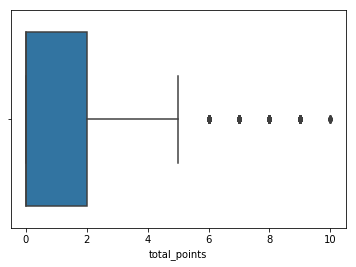

In [24]:
sns.boxplot(x=df['total_points'])

In [26]:
df.shape

(76145, 51)

In [25]:
df.to_csv("combined-season-data.csv", index=False);
df.to_csv("combined-season-data-impute.csv", index=False);